In [26]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [27]:
print("Numpy Version:", np.__version__)
print("TF Version:", tf.__version__)
print("TF Eager Mode:", tf.executing_eagerly())
print("Keras Version:", tf.keras.__version__)
print("TF Hub Version:", hub.__version__)
print("GPU is", 'Available', tf.test.is_gpu_available())
print("Available GPU list:", tf.config.list_physical_devices('GPU'))

Numpy Version: 2.1.3
TF Version: 2.19.0
TF Eager Mode: True
Keras Version: 3.10.0
TF Hub Version: 0.16.1
GPU is Available False
Available GPU list: []


In [28]:
train_data = tfds.load(
    'imdb_reviews',
    split='train',
    as_supervised=True,
    batch_size=-1
)
test_data = tfds.load(
    'imdb_reviews',
    split='test',
    as_supervised=True,
    batch_size=-1
)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples,  test_labels  = tfds.as_numpy(test_data)

print(f'Training entities: {len(train_examples)}.')
print(f'Test entities: {len(test_examples)}.')

Training entities: 25000.
Test entities: 25000.


In [44]:
# Hub URL for Swivel 20-dim text embeddings
hub_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"

# Lambda wrapper for TFHub module
def use_hub(text_input):
    module = hub.load(hub_url)
    return module(text_input)

# Input layer for string input
text_input = tf.keras.Input(shape=(), dtype=tf.string, name='text')

# Use Lambda to wrap the TF Hub model
embedding = tf.keras.layers.Lambda(use_hub, output_shape=(20,))(text_input)

# Add rest of the model
x = tf.keras.layers.Dense(16, activation='relu')(embedding)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create and compile model
model = tf.keras.Model(inputs=text_input, outputs=output)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text (InputLayer)               │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353 (1.38 KB)

 Trainable params: 353 (1.38 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [46]:
print(x_val.shape)
print(partial_x_train.shape)
print(y_val.shape)
print(partial_y_train.shape)

(10000,)
(15000,)
(10000,)
(15000,)


In [49]:
# Convert training and validation sets to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((partial_x_train, partial_y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(512).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(512).prefetch(tf.data.AUTOTUNE)

In [52]:
%%time
# Now train the model
history = model.fit(train_dataset,
                    epochs=40,
                    validation_data=val_dataset,
                    verbose=1)

Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7058 - loss: 0.5723 - val_accuracy: 0.6957 - val_loss: 0.5803
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7062 - loss: 0.5700 - val_accuracy: 0.6957 - val_loss: 0.5783
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7171 - loss: 0.5605 - val_accuracy: 0.6993 - val_loss: 0.5759
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7077 - loss: 0.5658 - val_accuracy: 0.6997 - val_loss: 0.5742
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7175 - loss: 0.5631 - val_accuracy: 0.7018 - val_loss: 0.5721
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7062 - loss: 0.5676 - val_accuracy: 0.7044 - val_loss: 0.5730
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7182 - loss: 0.5612 - val_accuracy: 0.7059 - val_loss: 0.5699
Epoch 8/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7096 - loss: 0.5664 - val_accuracy: 0.7035 - v

In [55]:
results = model.evaluate(val_dataset)
print(results)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7188 - loss: 0.5597
[0.555713951587677, 0.7188000082969666]


In [61]:
history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

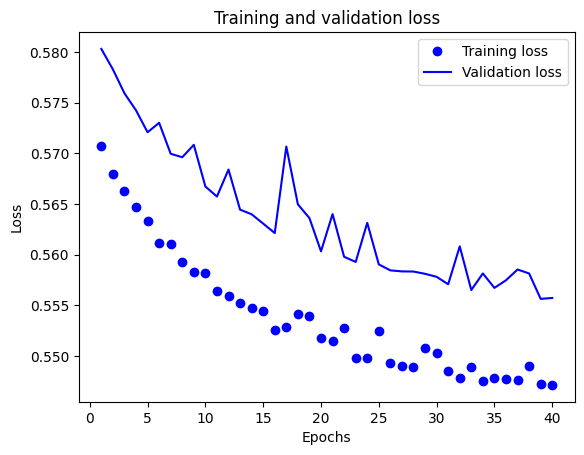

In [63]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

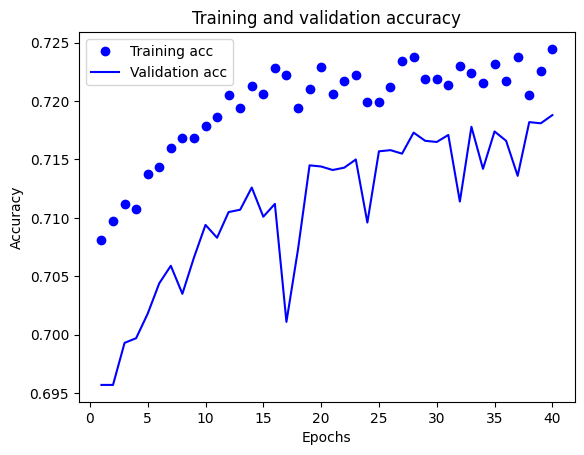

In [ ]:
plt.clf() # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [78]:
# Your input strings
texts = ["Great movie!", "Terrible plot and acting.", "It was okay, not the best.", "Don't want ever see it again", "Not gonna watch any of this director movie anymore"]

# Convert to tf.data.Dataset because of the way that we trained model we need to give data as a batch and with TF data type
predict_ds = tf.data.Dataset.from_tensor_slices(texts).batch(1)

# Predict
predictions = model.predict(predict_ds)

# Print results, if it is bigger than 0.5 means that is positive and if it is less than 0.5 means that is negative
for text, pred in zip(texts, predictions):
    print(f"{text} -> {pred[0]:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Great movie! -> 0.6680
Terrible plot and acting. -> 0.4768
It was okay, not the best. -> 0.3203
Don't want ever see it again -> 0.4090
Not gonna watch any of this director movie anymore -> 0.4185
